Computing basic statistics of data

In [10]:
import networkx as nx

# Load graph 
G = nx.read_graphml("../../dataExtracted/THE_GRAPH.graphml")
n_nodes=G.number_of_nodes()
n_edges=G.number_of_edges()
density= nx.density(G)
avg_degree= sum(dict(G.degree()).values()) / n_nodes
avg_clustering= nx.average_clustering(G)
largest_cc= max(nx.connected_components(G), key=len)
avg_shortest_path=nx.average_shortest_path_length(G.subgraph(largest_cc))
diameter=nx.diameter(G.subgraph(largest_cc))
print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges}")
print(f"Density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Average clustering coefficient: {avg_clustering:.3f}")
print(f"Average shortest path (largest CC): {avg_shortest_path:.2f}")
print(f"Diameter (largest CC): {diameter}")


Nodes: 1031
Edges: 1674
Density: 0.0032
Average degree: 3.25
Average clustering coefficient: 0.052
Average shortest path (largest CC): 8.82
Diameter (largest CC): 20


Degree distribution plot


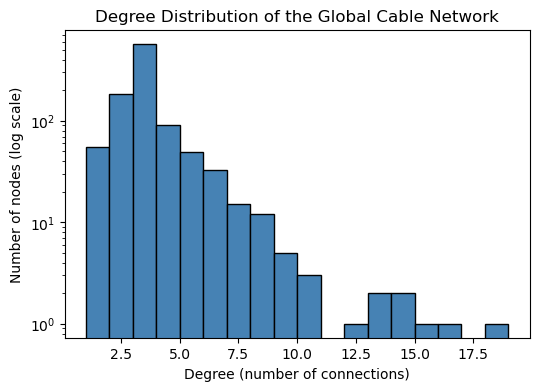

In [19]:
import matplotlib.pyplot as plt

degrees = [d for _, d in G.degree()]
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=range(1, max(degrees)+1), color='steelblue', edgecolor='black', log=True)
plt.xlabel("Degree (number of connections)")
plt.ylabel("Number of nodes (log scale)")
plt.title("Degree Distribution of the Global Cable Network")
plt.show()


Comparing clustering of the graph to a random graph

In [21]:
G_random = nx.gnm_random_graph(n_nodes, n_edges)
largest_cc_rnd = max(nx.connected_components(G_random), key=len)
G_largest_random = G_random.subgraph(largest_cc_rnd).copy()
print(f"Random graph clustering: {nx.average_clustering(G_random):.3f}")
print(f"Random graph avg path length (approx): {nx.average_shortest_path_length(G_largest_random):.2f}")

Random graph clustering: 0.002
Random graph avg path length (approx): 5.90
